# Phase 1


## Baseline MNIST Classifiers

Supervised baselines on raw MNIST pixels (flattened 28×28 → 784 features), without any feature selection or weighting. Models: Logistic Regression, MLP, XGBoost. Metrics: balanced accuracy and macro one-vs-rest ROC-AUC on the standard MNIST test set.

In [2]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, log_loss
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

SEED = 42
DATA_ROOT = Path("./notebooks/data")

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [3]:
transform = transforms.ToTensor()

train_ds = datasets.MNIST(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform,
)

test_ds = datasets.MNIST(
    root=DATA_ROOT,
    train=False,
    download=True,
    transform=transform,
)


def dataset_to_numpy(dataset, batch_size: int = 1024):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    xs, ys = [], []
    for imgs, labels in loader:
        xs.append(imgs.view(imgs.size(0), -1))
        ys.append(labels)
    X = torch.cat(xs).numpy()
    y = torch.cat(ys).numpy()
    return X, y

X_train, y_train = dataset_to_numpy(train_ds)
X_test, y_test = dataset_to_numpy(test_ds)

X_train.shape, X_test.shape


((60000, 784), (10000, 784))

In [4]:
def build_models(seed: int = 42):
    lr = LogisticRegression(
        max_iter=1,  # we loop manually to collect loss curve
        warm_start=True,
        multi_class="ovr",
        n_jobs=-1,
        random_state=seed,
    )

    mlp = MLPClassifier(
        hidden_layer_sizes=(64,), 
        activation="relu",
        solver="adam",
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=1,  # manual loop for curve
        warm_start=True,
        early_stopping=True,
        n_iter_no_change=5,
        random_state=seed,
    )

    xgb = XGBClassifier(
        objective="multi:softprob",
        num_class=10,
        eval_metric="mlogloss",
        tree_method="hist",
        n_estimators=150,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=seed,
        verbosity=0,
    )

    return {
        "LogisticRegression": lr,
        "MLPClassifier": mlp,
        "XGBoost": xgb,
    }


def evaluate_model(model, X_train, y_train, X_test, y_test, classes):
    # Train loss
    train_probs = model.predict_proba(X_train)
    train_loss = log_loss(y_train, train_probs, labels=classes)

    # Test metrics
    test_preds = model.predict(X_test)
    test_probs = model.predict_proba(X_test)
    y_bin = label_binarize(y_test, classes=classes)
    bal_acc = balanced_accuracy_score(y_test, test_preds)
    roc_auc = roc_auc_score(y_bin, test_probs, average="macro")
    test_loss = log_loss(y_test, test_probs, labels=classes)

    return {
        "train_log_loss": train_loss,
        "test_log_loss": test_loss,
        "balanced_accuracy": bal_acc,
        "roc_auc_ovr_macro": roc_auc,
    }


def fit_with_curves(name, model, X_train, y_train, X_test, y_test, classes, iterations=30):
    train_curve, test_curve = [], []

    if name == "XGBoost":
        # Use built-in evaluation logging
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False,
        )
        evals = model.evals_result()
        train_curve = evals["validation_0"]["mlogloss"]
        test_curve = evals["validation_1"]["mlogloss"]
        return model, train_curve, test_curve

    # For sklearn models, loop manually using warm_start
    for _ in range(iterations):
        model.fit(X_train, y_train)
        # Record losses after this iteration
        train_probs = model.predict_proba(X_train)
        test_probs = model.predict_proba(X_test)
        train_curve.append(log_loss(y_train, train_probs, labels=classes))
        test_curve.append(log_loss(y_test, test_probs, labels=classes))

    return model, train_curve, test_curve


### Training


In [5]:
models = build_models(seed=SEED)
classes = np.arange(10)
iterations = 30  # iterations for sklearn models' curves

# Optionally restrict which models to (re)train. Set to None to train all.
models_to_train = ["MLPClassifier"]

try:
    fitted_models
    loss_curves
except NameError:
    fitted_models = {}
    loss_curves = {}

for name, model in models.items():
    should_train = (models_to_train is None) or (name in models_to_train) or (name not in fitted_models)
    if should_train:
        print(f"Training {name}...")
        fitted, train_curve, test_curve = fit_with_curves(
            name,
            model,
            X_train,
            y_train,
            X_test,
            y_test,
            classes,
            iterations=iterations,
        )
        fitted_models[name] = fitted
        loss_curves[name] = {"train": train_curve, "test": test_curve}
    else:
        print(f"Skipping {name}, using existing fitted model.")

"done"


Training LogisticRegression...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\janag\AppData\Roaming\Python\Python313\site

Training MLPClassifier...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

Training XGBoost...


'done'

### Evaluation

In [6]:
results = []
for name, model in fitted_models.items():
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, classes=classes)
    results.append({"model": name, **metrics})

results_df = pd.DataFrame(results).set_index("model")
results_df


,train_log_loss,test_log_loss,balanced_accuracy,roc_auc_ovr_macro
model,,,,
LogisticRegression,0.441501,0.422629,0.904687,0.987975
MLPClassifier,0.024178,0.095622,0.974449,0.999398
XGBoost,0.013697,0.080438,0.975461,0.999578


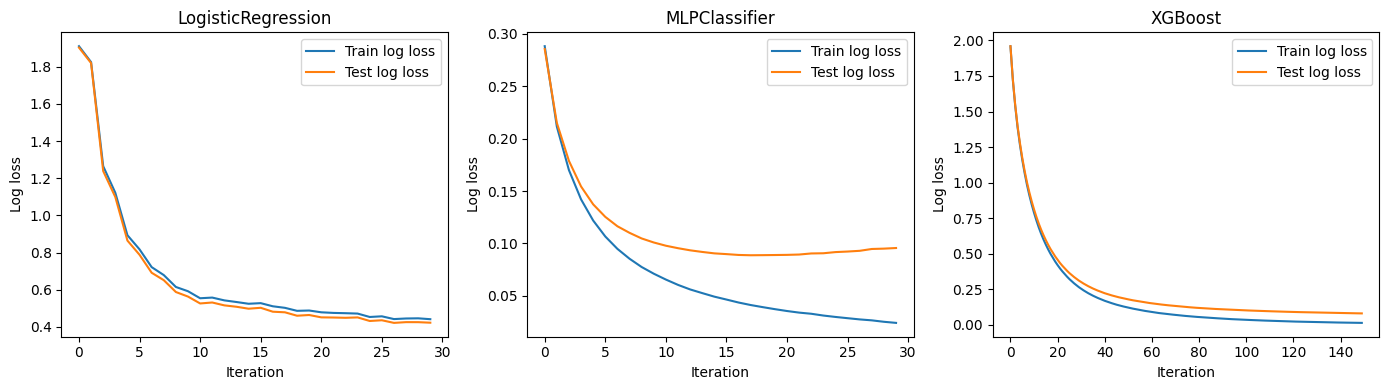

In [7]:
# Plot train/test log loss curves per model
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)
model_names = list(loss_curves.keys())

for ax, name in zip(axes, model_names):
    train_curve = loss_curves[name]["train"]
    test_curve = loss_curves[name]["test"]
    ax.plot(train_curve, label="Train log loss")
    ax.plot(test_curve, label="Test log loss")
    ax.set_title(name)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Log loss")
    ax.legend()

plt.tight_layout()
plt.show()



## FSL-Net based feature importance (one-vs-all)

We now compute a proxy feature importance vector using pre-trained FSL-Net: for each digit \(c\), we compare all MNIST train images of class \(c\) vs. all non-\(c\) images, obtain a 784-dim distributional shift map, and then average these 10 maps to get a global importance over pixels.


In [8]:
from fslnet.fslnet import FSLNet

# Load pre-trained FSL-Net (inference only)
fslnet_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using FSL-Net device: {fslnet_device}")

fslnet = FSLNet.from_pretrained(device=fslnet_device)



Using FSL-Net device: cpu
--> Loading FSLNet weights from 'C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\fslnet\checkpoints\fslnet.pth' onto cpu ...
--> FSLNet loaded and set to eval().


In [9]:
# Compute one-vs-all FSL-Net shift maps for each digit class
# To avoid huge memory usage, we subsample a fixed number of ref / non-ref images per class.

num_classes = 10
feature_dim = X_train.shape[1]
max_ref_per_class = 1000
max_not_ref_per_class = 1000

rng = np.random.default_rng(SEED)

shift_maps = []  # will hold 10 vectors of shape (784,)

for c in range(num_classes):
    print(f"Computing FSL-Net shift map for class {c} vs. rest ...")
    idx_c = np.where(y_train == c)[0]
    idx_not_c = np.where(y_train != c)[0]

    # Subsample for memory control and reproducibility
    if len(idx_c) > max_ref_per_class:
        idx_c = rng.choice(idx_c, size=max_ref_per_class, replace=False)
    if len(idx_not_c) > max_not_ref_per_class:
        idx_not_c = rng.choice(idx_not_c, size=max_not_ref_per_class, replace=False)

    ref_np = X_train[idx_c]   # (N_ref, 784)
    que_np = X_train[idx_not_c]  # (N_not_ref, 784)

    ref = torch.tensor(ref_np, dtype=torch.float32, device=fslnet_device)
    que = torch.tensor(que_np, dtype=torch.float32, device=fslnet_device)

    with torch.no_grad():
        soft_predictions, _ = fslnet(ref, que)

    P_c = soft_predictions.squeeze(0).cpu().numpy()  # (784,)
    shift_maps.append(P_c)

shift_maps = np.stack(shift_maps, axis=0)  # (10, 784)
print("shift_maps shape:", shift_maps.shape)



Computing FSL-Net shift map for class 0 vs. rest ...
Computing FSL-Net shift map for class 1 vs. rest ...
Computing FSL-Net shift map for class 2 vs. rest ...
Computing FSL-Net shift map for class 3 vs. rest ...
Computing FSL-Net shift map for class 4 vs. rest ...
Computing FSL-Net shift map for class 5 vs. rest ...
Computing FSL-Net shift map for class 6 vs. rest ...
Computing FSL-Net shift map for class 7 vs. rest ...
Computing FSL-Net shift map for class 8 vs. rest ...
Computing FSL-Net shift map for class 9 vs. rest ...
shift_maps shape: (10, 784)


importance_vector shape: (784,)
importance range:  0.0 1.0


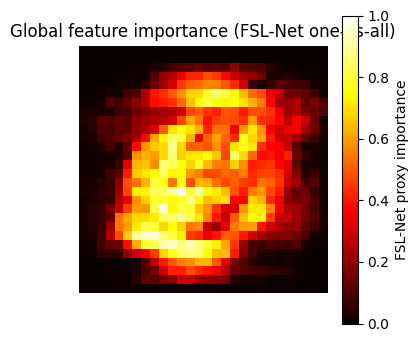

In [10]:
# Aggregate to a global importance vector and normalize to [0, 1]

importance_vector_raw = shift_maps.mean(axis=0)  # (784,)

imp_min = importance_vector_raw.min()
imp_max = importance_vector_raw.max()
if imp_max > imp_min:
    importance_vector = (importance_vector_raw - imp_min) / (imp_max - imp_min)
else:
    importance_vector = np.zeros_like(importance_vector_raw)

print("importance_vector shape:", importance_vector.shape)
print("importance range: ", float(importance_vector.min()), float(importance_vector.max()))

# Visualize as a 28x28 heatmap
plt.figure(figsize=(4, 4))
plt.imshow(importance_vector.reshape(28, 28), cmap="hot")
plt.colorbar(label="FSL-Net proxy importance")
plt.title("Global feature importance (FSL-Net one-vs-all)")
plt.axis("off")
plt.show()



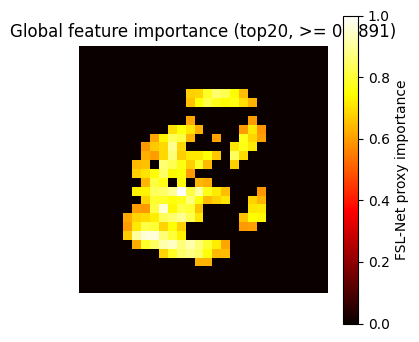

Number of features kept for top20: 157


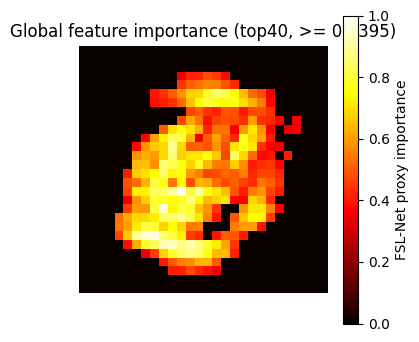

Number of features kept for top40: 314


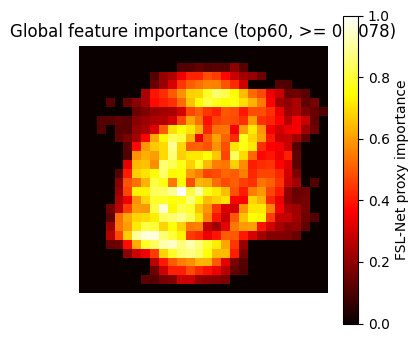

Number of features kept for top60: 470


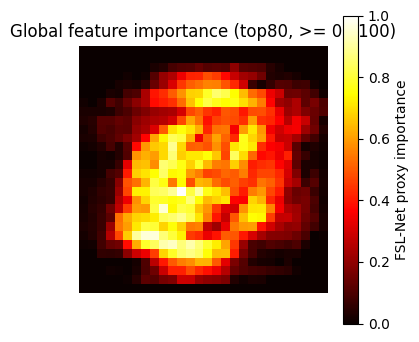

Number of features kept for top80: 627


In [11]:
# Visualize as 28x28 heatmaps for top 20%, 40%, 60%, 80%
percentiles_to_plot = {"top20": 80.0, "top40": 60.0, "top60": 40.0, "top80": 20.0}

for name, p in percentiles_to_plot.items():
    thr = np.percentile(importance_vector, p)
    plt.figure(figsize=(4, 4))
    masked_importance = np.zeros_like(importance_vector)
    masked_importance[importance_vector >= thr] = importance_vector[importance_vector >= thr]
    plt.imshow(masked_importance.reshape(28, 28), cmap="hot")
    plt.colorbar(label="FSL-Net proxy importance")
    plt.title(f"Global feature importance ({name}, >= {thr:.4f})")
    plt.axis("off")
    plt.show()
    print(f"Number of features kept for {name}: {len(masked_importance[masked_importance > 0])}")

In [12]:
# Feature selection masks and weighted datasets based on FSL-Net importance

# Top-k percentiles (keep top 20%, 40%, 60%, 80% by importance)
percentiles = {
    "top20": 80.0,
    "top40": 60.0,
    "top60": 40.0,
    "top80": 20.0,
}

n_features_baseline = X_train.shape[1]
thresholds = {name: np.percentile(importance_vector, p) for name, p in percentiles.items()}
masks = {name: importance_vector >= thr for name, thr in thresholds.items()}
n_features = {name: int(mask.sum()) for name, mask in masks.items()}

print(f"Baseline features: {n_features_baseline}")
for name, thr in thresholds.items():
    print(f"Features kept for {name} (threshold {thr:.4f}): {n_features[name]}")

# Feature-selected datasets (same transform for train/test)
X_train_top20 = X_train[:, masks["top20"]]
X_test_top20 = X_test[:, masks["top20"]]

X_train_top40 = X_train[:, masks["top40"]]
X_test_top40 = X_test[:, masks["top40"]]

X_train_top60 = X_train[:, masks["top60"]]
X_test_top60 = X_test[:, masks["top60"]]

X_train_top80 = X_train[:, masks["top80"]]
X_test_top80 = X_test[:, masks["top80"]]

# Feature-weighted datasets (element-wise weighting, keep all 784 features)
X_train_weighted = X_train * importance_vector
X_test_weighted = X_test * importance_vector



Baseline features: 784
Features kept for top20 (threshold 0.5891): 157
Features kept for top40 (threshold 0.3395): 314
Features kept for top60 (threshold 0.1078): 470
Features kept for top80 (threshold 0.0100): 627


In [13]:
# Helper: train and evaluate the three baseline models on a given feature set

def train_and_evaluate_on_features(X_tr, X_te, y_tr, y_te, classes, seed: int = SEED):
    models_local = build_models(seed=seed)
    scenario_results = {}
    for name, model in models_local.items():
        print(f"Training {name} on {X_tr.shape[1]} features ...")
        fitted = model.fit(X_tr, y_tr)
        metrics = evaluate_model(fitted, X_tr, y_tr, X_te, y_te, classes=classes)
        scenario_results[name] = metrics
    return scenario_results

# Re-train models for each FSL-Net–based transformation

results_top20 = train_and_evaluate_on_features(X_train_top20, X_test_top20, y_train, y_test, classes)
results_top40 = train_and_evaluate_on_features(X_train_top40, X_test_top40, y_train, y_test, classes)
results_top60 = train_and_evaluate_on_features(X_train_top60, X_test_top60, y_train, y_test, classes)
results_top80 = train_and_evaluate_on_features(X_train_top80, X_test_top80, y_train, y_test, classes)
results_weighted = train_and_evaluate_on_features(X_train_weighted, X_test_weighted, y_train, y_test, classes)



Training LogisticRegression on 157 features ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training MLPClassifier on 157 features ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Training XGBoost on 157 features ...
Training LogisticRegression on 314 features ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training MLPClassifier on 314 features ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Training XGBoost on 314 features ...
Training LogisticRegression on 470 features ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training MLPClassifier on 470 features ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Training XGBoost on 470 features ...
Training LogisticRegression on 627 features ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training MLPClassifier on 627 features ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Training XGBoost on 627 features ...
Training LogisticRegression on 784 features ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training MLPClassifier on 784 features ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Training XGBoost on 784 features ...


In [14]:
# Build comparison tables: scenario-level and per-model

def dict_to_df(res_dict):
    rows = []
    for model_name, metrics in res_dict.items():
        rows.append({"model": model_name, **metrics})
    return pd.DataFrame(rows).set_index("model")

# Baseline results are already in results_df (from earlier cells)

df_baseline = results_df.copy()
df_top20 = dict_to_df(results_top20)
df_top40 = dict_to_df(results_top40)
df_top60 = dict_to_df(results_top60)
df_top80 = dict_to_df(results_top80)
df_weighted = dict_to_df(results_weighted)

# Scenario-level summary: average metrics across the three models
summary_rows = []
summary_rows.append({
    "scenario": "Baseline",
    "n_features": n_features_baseline,
    "balanced_accuracy": df_baseline["balanced_accuracy"].mean(),
    "roc_auc_ovr_macro": df_baseline["roc_auc_ovr_macro"].mean(),
})
summary_rows.append({
    "scenario": "Top 20%",
    "n_features": n_features["top20"],
    "balanced_accuracy": df_top20["balanced_accuracy"].mean(),
    "roc_auc_ovr_macro": df_top20["roc_auc_ovr_macro"].mean(),
})
summary_rows.append({
    "scenario": "Top 40%",
    "n_features": n_features["top40"],
    "balanced_accuracy": df_top40["balanced_accuracy"].mean(),
    "roc_auc_ovr_macro": df_top40["roc_auc_ovr_macro"].mean(),
})
summary_rows.append({
    "scenario": "Top 60%",
    "n_features": n_features["top60"],
    "balanced_accuracy": df_top60["balanced_accuracy"].mean(),
    "roc_auc_ovr_macro": df_top60["roc_auc_ovr_macro"].mean(),
})
summary_rows.append({
    "scenario": "Top 80%",
    "n_features": n_features["top80"],
    "balanced_accuracy": df_top80["balanced_accuracy"].mean(),
    "roc_auc_ovr_macro": df_top80["roc_auc_ovr_macro"].mean(),
})
summary_rows.append({
    "scenario": "Weighted",
    "n_features": n_features_baseline,
    "balanced_accuracy": df_weighted["balanced_accuracy"].mean(),
    "roc_auc_ovr_macro": df_weighted["roc_auc_ovr_macro"].mean(),
})

summary_df = pd.DataFrame(summary_rows).set_index("scenario")
print("Scenario-level comparison (averaged over models):")
print(summary_df)

# Optional: full per-model table for detailed inspection
full = []
for scen_name, df, n_feat in [
    ("Baseline", df_baseline, n_features_baseline),
    ("Top 20%", df_top20, n_features["top20"]),
    ("Top 40%", df_top40, n_features["top40"]),
    ("Top 60%", df_top60, n_features["top60"]),
    ("Top 80%", df_top80, n_features["top80"]),
    ("Weighted", df_weighted, n_features_baseline),
]:
    df_tmp = df.copy()
    df_tmp["scenario"] = scen_name
    df_tmp["n_features"] = n_feat
    full.append(df_tmp.reset_index())

full_df = pd.concat(full, ignore_index=True).set_index(["scenario", "model"])
print("\nPer-model metrics by scenario:")
print(full_df)



Scenario-level comparison (averaged over models):
          n_features  balanced_accuracy  roc_auc_ovr_macro
scenario                                                  
Baseline         784           0.951532           0.995650
Top 20%          157           0.833368           0.975973
Top 40%          314           0.860330           0.983621
Top 60%          470           0.868263           0.984948
Top 80%          627           0.869047           0.985012
Weighted         784           0.857736           0.980488

Per-model metrics by scenario:
                             train_log_loss  test_log_loss  balanced_accuracy  \
scenario model                                                                  
Baseline LogisticRegression        0.441501       0.422629           0.904687   
         MLPClassifier             0.024178       0.095622           0.974449   
         XGBoost                   0.013697       0.080438           0.975461   
Top 20%  LogisticRegression        1.9896

In [15]:
# Classifier-derived feature importance (baseline models)

from pathlib import Path

fi_dir = Path("notebooks/feature_importance_classifiers")
fi_dir.mkdir(parents=True, exist_ok=True)

feature_importances = {}

for name, model in fitted_models.items():
    if name == "LogisticRegression":
        # coef_: (n_classes, n_features). Use mean absolute weight per feature.
        coefs = model.coef_  # shape (C, 784)
        imp = np.mean(np.abs(coefs), axis=0)
    elif name == "MLPClassifier":
        # First-layer weights: (n_features, hidden_units). Use L2 norm per input feature.
        W0 = model.coefs_[0]  # shape (784, H)
        imp = np.linalg.norm(W0, axis=1)
    elif name == "XGBoost":
        # Built-in feature importance (gain-based by default).
        imp = model.feature_importances_.copy()
    else:
        continue

    # Normalize to [0,1] for comparability
    imp_min = imp.min()
    imp_max = imp.max()
    if imp_max > imp_min:
        imp_norm = (imp - imp_min) / (imp_max - imp_min)
    else:
        imp_norm = np.zeros_like(imp)

    feature_importances[name] = imp_norm

    out_path = fi_dir / f"feature_importance_{name}.npy"
    np.save(out_path, imp_norm)
    print(f"Saved {name} feature importance to {out_path} with shape {imp_norm.shape}")

feature_importances


Saved LogisticRegression feature importance to notebooks\feature_importance_classifiers\feature_importance_LogisticRegression.npy with shape (784,)
Saved MLPClassifier feature importance to notebooks\feature_importance_classifiers\feature_importance_MLPClassifier.npy with shape (784,)
Saved XGBoost feature importance to notebooks\feature_importance_classifiers\feature_importance_XGBoost.npy with shape (784,)


{'LogisticRegression': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.43422999e-04, 8.59007907e-04, 3.65749784e-04, 1.52395749e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.27630160e-05, 5.53205808e-05, 1.37965416e-03, 3.32858641e-03,
        4.97895695e-03, 6.17491660e-03, 1.09420265e-02, 1.37660457e-02,
        1.69638503e-02, 1.43044278e-02, 1.29756736e-02, 1.21015200e-02,
        1.08943518e-02, 1.02796475e-02, 7.47268932e-03, 6.04897052e-03,
        4.52743684e-03, 2.44809264e-03, 1.29159826e-03, 4.13960681e-04,
        0.00000000e+00, 0.00000000e+00, 0.

## Phase 2: Evaluation with fine-tuned FSL-Net

We now reuse the Phase 1 pipeline with FSL-Net models that have been fine-tuned to match classifier-derived feature importance (LogReg, MLP, XGBoost). For each fine-tuned FSL-Net, we recompute a global one-vs-all importance map, apply the same percentile-based feature selection and weighting strategies, retrain the three classifiers with identical hyperparameters, and summarize the resulting metrics.


In [22]:
from pathlib import Path

# Helper: recompute a normalized importance vector from a (possibly fine-tuned) FSL-Net checkpoint

def compute_fsl_importance_from_checkpoint(ckpt_path: Path,
                                            max_ref_per_class: int = 1000,
                                            max_not_ref_per_class: int = 1000,
                                            seed: int = SEED):
    device = fslnet_device if "fslnet_device" in globals() else ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Loading FSL-Net weights from {ckpt_path} on {device} ...")

    # Start from the same pre-trained backbone, then load fine-tuned weights
    model = FSLNet.from_pretrained(device=device)
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.eval()

    num_classes = 10
    feature_dim = X_train.shape[1]

    rng = np.random.default_rng(seed)
    shift_maps_ft = []

    for c in range(num_classes):
        print(f"[FSL fine-tuned] Computing shift map for class {c} vs. rest ...")
        idx_c = np.where(y_train == c)[0]
        idx_not_c = np.where(y_train != c)[0]

        if len(idx_c) > max_ref_per_class:
            idx_c = rng.choice(idx_c, size=max_ref_per_class, replace=False)
        if len(idx_not_c) > max_not_ref_per_class:
            idx_not_c = rng.choice(idx_not_c, size=max_not_ref_per_class, replace=False)

        ref_np = X_train[idx_c]
        que_np = X_train[idx_not_c]

        ref = torch.tensor(ref_np, dtype=torch.float32, device=device)
        que = torch.tensor(que_np, dtype=torch.float32, device=device)

        with torch.no_grad():
            soft_predictions, _ = model(ref, que)

        P_c = soft_predictions.squeeze(0).cpu().numpy()  # (784,)
        shift_maps_ft.append(P_c)

    shift_maps_ft = np.stack(shift_maps_ft, axis=0)  # (10, 784)
    importance_raw = shift_maps_ft.mean(axis=0)

    imp_min = importance_raw.min()
    imp_max = importance_raw.max()
    if imp_max > imp_min:
        importance_vec = (importance_raw - imp_min) / (imp_max - imp_min)
    else:
        importance_vec = np.zeros_like(importance_raw)

    print("FSL-Net fine-tuned importance shape:", importance_vec.shape)
    print("Range:", float(importance_vec.min()), float(importance_vec.max()))
    return importance_vec


In [23]:
# Helper: evaluate the Phase 1 classifiers with a given importance vector


def evaluate_with_importance(label: str, importance_vec: np.ndarray, model_keys=None):
    print(f"=== Evaluating with importance from {label} ===")

    # Define the same percentile levels as in Phase 1
    percentile_map = {"top20": 80.0, "top40": 60.0, "top60": 40.0, "top80": 20.0}

    # Compute thresholds
    thresholds = {name: np.percentile(importance_vec, p) for name, p in percentile_map.items()}

    # Build feature masks
    masks = {}
    for key, perc in enumerate(percentile_map.values()):
        threshold = list(percentile_map.keys())[key]
        thr = thresholds[threshold]
        masks[threshold] = importance_vec >= thr

    # Report number of selected features
    print("Selected features per strategy:")
    for key, mask in masks.items():
        print(f"  {key}: {mask.sum()} / {len(mask)}")

    # Build per-scenario feature matrices
    Xtr_top20 = X_train[:, masks["top20"]]
    Xte_top20 = X_test[:, masks["top20"]]
    Xtr_top40 = X_train[:, masks["top40"]]
    Xte_top40 = X_test[:, masks["top40"]]
    Xtr_top60 = X_train[:, masks["top60"]]
    Xte_top60 = X_test[:, masks["top60"]]
    Xtr_top80 = X_train[:, masks["top80"]]
    Xte_top80 = X_test[:, masks["top80"]]

    # Weighted versions (using full importance vector)
    Xtr_w = X_train * importance_vec
    Xte_w = X_test * importance_vec

    # Reuse baseline models for hyperparameters (LogReg, MLP, XGBoost)
    models_ft = build_models(seed=SEED)
    if model_keys is not None:
        models_ft = {k: v for k, v in models_ft.items() if k in model_keys}

    def run_scenarios(Xtr_dict, Xte_dict):
        results = {}
        for mname, base_model in models_ft.items():
            # Clone a fresh model instance to avoid interference
            params = base_model.get_params()
            # Disable warm_start so we can safely change feature dimensionality
            if "warm_start" in params:
                params["warm_start"] = False
            model = type(base_model)(**params)
            # Train/eval on each mask scenario
            for key, Xtr_s in Xtr_dict.items():
                print(f"Training {mname} with {label} - {key} ...")
                Xte_s = Xte_dict[key]
                fitted = model.fit(Xtr_s, y_train)
                metrics = evaluate_model(fitted, Xtr_s, y_train, Xte_s, y_test, classes=classes)
                results.setdefault(key, {})[mname] = metrics
        return results

    Xtr_scen = {
        "Top20": Xtr_top20,
        "Top40": Xtr_top40,
        "Top60": Xtr_top60,
        "Top80": Xtr_top80,
        "Weighted": Xtr_w,
    }
    Xte_scen = {
        "Top20": Xte_top20,
        "Top40": Xte_top40,
        "Top60": Xte_top60,
        "Top80": Xte_top80,
        "Weighted": Xte_w,
    }

    results = run_scenarios(Xtr_scen, Xte_scen)

    # Build summary table (similar format as Phase 1)
    def dict_to_df_local(d):
        rows = []
        for mname, mets in d.items():
            row = {"model": mname}
            row.update(mets)
            rows.append(row)
        return pd.DataFrame(rows).set_index("model")

    summary_rows = []
    for scen_name in ["Top20", "Top40", "Top60", "Top80", "Weighted"]:
        scen_res = results.get(scen_name, {})
        df_scen = dict_to_df_local(scen_res)
        if df_scen.empty:
            continue
        row = {
            "model": scen_name,
            "train_log_loss": df_scen["train_log_loss"].mean(),
            "test_log_loss": df_scen["test_log_loss"].mean(),
            "balanced_accuracy": df_scen["balanced_accuracy"].mean(),
            "roc_auc_ovr_macro": df_scen["roc_auc_ovr_macro"].mean(),
        }
        summary_rows.append(row)

    summary_df = pd.DataFrame(summary_rows).set_index("model")
    print(summary_df.to_markdown(floatfmt=".4f"))

    return results, summary_df



In [24]:
# Run Phase 2 evaluation for each fine-tuned FSL-Net

finetuned_paths = {
    "logreg": Path("models/fsl_finetuned_logreg.pth"),
    "mlp": Path("models/fsl_finetuned_mlp.pth"),
    "xgb": Path("models/fsl_finetuned_xgb.pth"),
}

phase2_results = {}
phase2_summaries = {}

model_key_map = {
    "logreg": "LogisticRegression",
    "mlp": "MLPClassifier",
    "xgb": "XGBoost",
}

for name, ckpt in finetuned_paths.items():
    if not ckpt.exists():
        print(f"[WARN] Checkpoint not found: {ckpt}, skipping.")
        continue
    imp_vec = compute_fsl_importance_from_checkpoint(ckpt)
    target_model_key = model_key_map[name]
    res, summ = evaluate_with_importance(f"FSL fine-tuned {name}", imp_vec, model_keys=[target_model_key])
    phase2_results[name] = res
    phase2_summaries[name] = summ

phase2_summaries


Loading FSL-Net weights from models\fsl_finetuned_logreg.pth on cpu ...
[FSL fine-tuned] Computing shift map for class 0 vs. rest ...
[FSL fine-tuned] Computing shift map for class 1 vs. rest ...
[FSL fine-tuned] Computing shift map for class 2 vs. rest ...
[FSL fine-tuned] Computing shift map for class 3 vs. rest ...
[FSL fine-tuned] Computing shift map for class 4 vs. rest ...
[FSL fine-tuned] Computing shift map for class 5 vs. rest ...
[FSL fine-tuned] Computing shift map for class 6 vs. rest ...
[FSL fine-tuned] Computing shift map for class 7 vs. rest ...
[FSL fine-tuned] Computing shift map for class 8 vs. rest ...
[FSL fine-tuned] Computing shift map for class 9 vs. rest ...
FSL-Net fine-tuned importance shape: (784,)
Range: 0.0 1.0
=== Evaluating with importance from FSL fine-tuned logreg ===
Selected features per strategy:
  top20: 157 / 784
  top40: 314 / 784
  top60: 470 / 784
  top80: 627 / 784
Training LogisticRegression with FSL fine-tuned logreg - Top20 ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training LogisticRegression with FSL fine-tuned logreg - Top40 ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training LogisticRegression with FSL fine-tuned logreg - Top60 ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training LogisticRegression with FSL fine-tuned logreg - Top80 ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training LogisticRegression with FSL fine-tuned logreg - Weighted ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1273: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


| model    |   train_log_loss |   test_log_loss |   balanced_accuracy |   roc_auc_ovr_macro |
|:---------|-----------------:|----------------:|--------------------:|--------------------:|
| Top20    |           1.9948 |          1.9882 |              0.6688 |              0.9464 |
| Top40    |           1.9254 |          1.9174 |              0.6955 |              0.9591 |
| Top60    |           1.9115 |          1.9036 |              0.7084 |              0.9610 |
| Top80    |           1.9104 |          1.9027 |              0.7083 |              0.9612 |
| Weighted |           2.0593 |          2.0540 |              0.6880 |              0.9516 |
Loading FSL-Net weights from models\fsl_finetuned_mlp.pth on cpu ...
[FSL fine-tuned] Computing shift map for class 0 vs. rest ...
[FSL fine-tuned] Computing shift map for class 1 vs. rest ...
[FSL fine-tuned] Computing shift map for class 2 vs. rest ...
[FSL fine-tuned] Computing shift map for class 3 vs. rest ...
[FSL fine-tuned] Computin

C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Training MLPClassifier with FSL fine-tuned mlp - Top40 ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Training MLPClassifier with FSL fine-tuned mlp - Top60 ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Training MLPClassifier with FSL fine-tuned mlp - Top80 ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Training MLPClassifier with FSL fine-tuned mlp - Weighted ...


C:\Users\janag\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


| model    |   train_log_loss |   test_log_loss |   balanced_accuracy |   roc_auc_ovr_macro |
|:---------|-----------------:|----------------:|--------------------:|--------------------:|
| Top20    |           0.8268 |          0.8097 |              0.7555 |              0.9627 |
| Top40    |           0.5394 |          0.5162 |              0.8534 |              0.9837 |
| Top60    |           0.4096 |          0.3989 |              0.8884 |              0.9892 |
| Top80    |           0.3189 |          0.3076 |              0.9161 |              0.9932 |
| Weighted |           0.3747 |          0.3641 |              0.9036 |              0.9913 |
Loading FSL-Net weights from models\fsl_finetuned_xgb.pth on cpu ...
[FSL fine-tuned] Computing shift map for class 0 vs. rest ...
[FSL fine-tuned] Computing shift map for class 1 vs. rest ...
[FSL fine-tuned] Computing shift map for class 2 vs. rest ...
[FSL fine-tuned] Computing shift map for class 3 vs. rest ...
[FSL fine-tuned] Computin

{'logreg':           train_log_loss  test_log_loss  balanced_accuracy  roc_auc_ovr_macro
 model                                                                        
 Top20           1.994808       1.988193           0.668843           0.946395
 Top40           1.925417       1.917446           0.695547           0.959115
 Top60           1.911465       1.903643           0.708360           0.961006
 Top80           1.910446       1.902698           0.708342           0.961175
 Weighted        2.059345       2.053984           0.688010           0.951639,
 'mlp':           train_log_loss  test_log_loss  balanced_accuracy  roc_auc_ovr_macro
 model                                                                        
 Top20           0.826760       0.809685           0.755506           0.962687
 Top40           0.539378       0.516240           0.853422           0.983719
 Top60           0.409628       0.398856           0.888425           0.989223
 Top80           0.318912       0.